### Towards grapher 0.3

Formatting (recession bars, end point, end point label, etc)

In [1]:
import pandas as pd
import numpy as np
import os

os.chdir('/home/brian/Documents/CPS/data/clean')

%matplotlib inline

In [6]:
keep_cols = ['HRMONTH', 'EMP', 'PWSSWGT', 'AGE', 'STATE']
state1 = ['KY', 'TN']
state2 = ['OH', 'IN']
calcs = [('Kentucky and Tennessee', '25 <= AGE <= 54 and STATE in @state1'),
         ('Ohio and Indiana', '25 <= AGE <= 54 and STATE in @state2')]

In [7]:
wm = lambda x: np.average(x, weights=df.loc[x.index, 'PWSSWGT']) * 100
mask = ' or '.join([f'({c[1]})' for c in calcs])
grouper = lambda x: pd.Categorical(
    np.where(x.eval(calcs[0][1]), calcs[0][0], calcs[1][0]))

In [8]:
data = pd.DataFrame()
for year in range(1994, 2019):
    df = (pd.read_feather(f'cps{year}.ft')
            .filter(keep_cols)
            .query(mask)
            .assign(GROUP = grouper))
    result = (df.groupby(['HRMONTH', 'GROUP'])
                .agg({'EMP': wm})).unstack()['EMP']
    result.index = pd.to_datetime([f'{year}-{i}-01' for i in result.index])
    data = data.append(result)

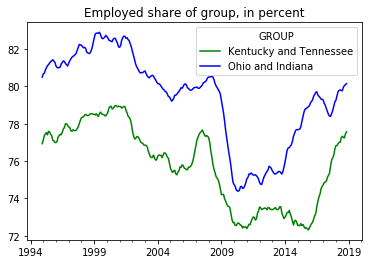

In [9]:
title = 'Employed share of group, in percent'
plot = data.rolling(12).mean().plot(title=title, color=['green', 'blue'])